# Squeezing in atomic qudits

In this notebook we will look into experiments with atomic qudits and reproduce them with pennylane. We first want to look at what we are trying to reproduce with pennylane. The graph below is from a [paper](https://arxiv.org/abs/1507.03782) by Helmut Strobel. In this paper the collective spin of a Bose-Einstein-Condensate is used to observe nonlinearity in spin squeezing.

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

%config InlineBackend.figure_format='retina'

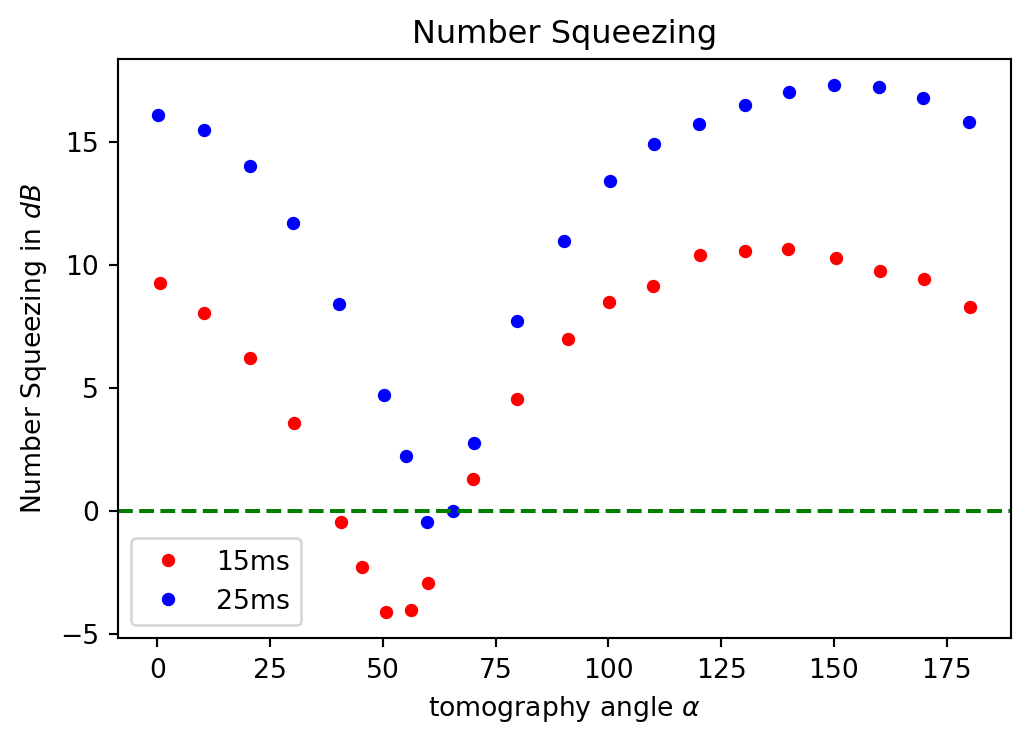

In [2]:
data_strobel_15 = pd.read_csv('Data/Strobel_Data_15ms.csv', names = ['dB', "alpha"])
data_strobel_25 = pd.read_csv('Data/Strobel_Data_25ms.csv', names = ['dB', "alpha"])

plt.figure(dpi=96)
plt.title("Number Squeezing")
plt.plot(data_strobel_15.dB, data_strobel_15.alpha, 'ro', label="15ms", markersize=4)
plt.plot(data_strobel_25.dB, data_strobel_25.alpha, 'bo', label="25ms", markersize=4)
plt.axhline(y=0, color='g', linestyle='--')
plt.ylabel(r'Number Squeezing in $dB$')
plt.xlabel(r'tomography angle $\alpha$')
_ = plt.legend()

This number squeezing is achieved by performing the following Bloch-sphere rotations. 

We prepare the collective spin such that the Bloch-sphere-vector points to one of the poles. 


1. __First step__.  As a first step the vector is rotated onto the equator.

![first step](Bloch_spheres/1.png)


2. __Second step__ . Then the state is being squeezed, such that it starts to wrap around the Bloch-sphere.

![second step](Bloch_spheres/2.png)


3. __Third step__ . In the last step we rotate the state around the $X$-axis. This rotation corresponds to the angle $\alpha$ in this notebook.


![third step](Bloch_spheres/alpha.png)

We will now simulate the sequence in pennylane.

In [3]:
import pennylane as qml
import numpy as np

from pennylane_ls import *

import the credentials to access the server and import the device. Make sure that you followed the necessary steps for obtaining the credentials as desribed in the [introduction](https://synqs.github.io/pennylane-ls/intro.html).

In [4]:
from credentials import username, password

nshots = 500

testDevice = qml.device("synqs.sqs", shots = nshots, username = username, password = password)

This created a single qudit device, which has the following operations.

In [5]:
testDevice.operations

{'load', 'rLx', 'rLz', 'rLz2'}

we now define the quantum circuit that implements the experimental sequence

In [6]:
@qml.qnode(testDevice)
def quantum_circuit(Nat = 10, theta = 0, kappa = 0, alpha=0, Ntrott = 2):
    '''
    The circuit that simulates the experiments.
    
    theta ... angle of the Lx term in the Hamiltonian evolution
    kappa ... angle of the Lz^2 term in the Hamiltonian evolution
    apla ... angle of rotation
    '''
    # load atoms
    SingleQuditOps.load(Nat,wires=0)
    
    # rotate onto x
    SingleQuditOps.rLx(np.pi/2,wires=0)
    SingleQuditOps.rLz(np.pi/2,wires=0)
    
    # evolution under the Hamiltonian
    for ii in range(Ntrott):
        SingleQuditOps.rLx(theta/Ntrott, wires=0)
        SingleQuditOps.rLz2(kappa/Ntrott, wires=0)

    # and the final rotation to test the variance
    SingleQuditOps.rLx(-alpha, wires=0)
    return qml.var(SingleQuditOps.Z(0))

the parameters of the experiment.

In [7]:
Nat = 200;
l = Nat/2 # spin length
omegax = 2*np.pi*20;
t1 = 15e-3;
t2 = 25e-3;
Lambda = 1.5;#1.5

chi = Lambda*abs(omegax)/Nat;

Ntrott = 15;

let us visualize it once.

In [8]:
quantum_circuit(Nat, omegax*t1, chi*t1, 0,Ntrott)

tensor(443.1044, requires_grad=True)

In [9]:
print(quantum_circuit.draw())

 0: ──load(200)──rLx(1.57)──rLz(1.57)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0.126)──rLz2(0.000942)──rLx(0)──┤ Var[Z] 



and now calculate the variance as presented above.

In [10]:
alphas = np.linspace(0, np.pi, 15)
variances_1 = np.zeros(len(alphas))
variances_2 = np.zeros(len(alphas))

for i in range(len(alphas)):
    if i%10==0:
        print("step", i)
    # Calculate the resulting states after each rotation
    variances_1[i] = quantum_circuit(Nat, omegax*t1, chi*t1, alphas[i],Ntrott)
    variances_2[i] = quantum_circuit(Nat, omegax*t2, chi*t2, alphas[i],Ntrott)

step 0
step 10


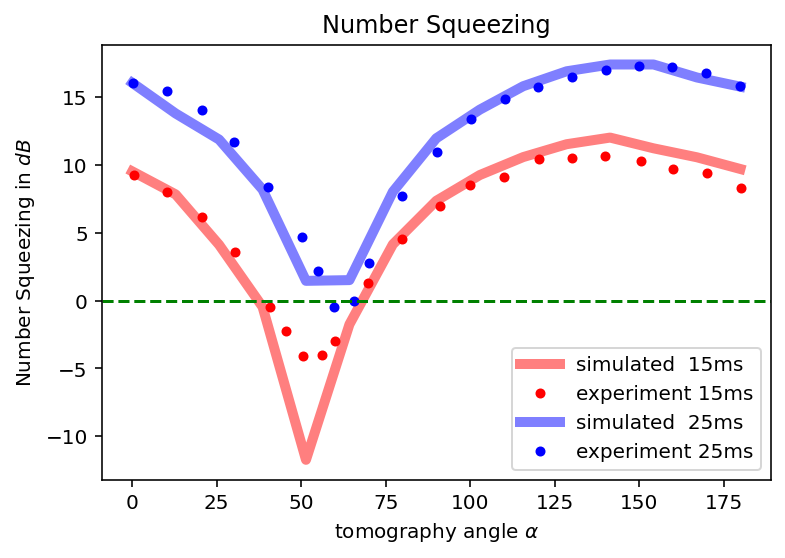

In [11]:
def number_squeezing_factor_to_db(var_CSS, var):
    return 10*np.log10(var/var_CSS)

f, ax = plt.subplots()
ax.set_title("Number Squeezing")
plt.plot(np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_1),'r-', lw = 5, label="simulated  15ms", alpha = 0.5)
ax.plot(data_strobel_15.dB, data_strobel_15.alpha, 'ro', label="experiment 15ms", markersize=4)
plt.plot(np.rad2deg(alphas), number_squeezing_factor_to_db(l/2, variances_2),'b-', lw = 5, label="simulated  25ms", alpha = 0.5)
ax.plot(data_strobel_25.dB, data_strobel_25.alpha, 'bo', label="experiment 25ms", markersize=4)
ax.axhline(y=0, color='g', linestyle='--')
ax.set_ylabel(r'Number Squeezing in $dB$')
ax.set_xlabel(r'tomography angle $\alpha$')
ax.legend()